# Importación liberias

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, classification_report, confusion_matrix, roc_curve

# Carga datos

Cargamos los distintos Csv que hemos preparado para entrenar los modelos, estos se encuentran en la carpeta `data/processed`

In [7]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data", "processed")

file_name = "Propensity_clean_v1.csv"  # Cambiar a "v2", "v3", "v4" para trabajar con ostros csv
file_path = os.path.join(DATA_DIR, file_name)

df = pd.read_csv(file_path)

# Búsqueda Hiperparámetros

Probando: n_estimators=200, learning_rate=0.1, max_depth=4, min_child_weight=1, gamma=0.2, subsample=0.8, colsample_bytree=0.7
Accuracy: 0.8320, F1 Score: 0.8296, Precision: 0.8293, Recall: 0.8320, ROC-AUC: 0.9204
CV Score: 0.9215, Train Score: 0.8528, Overfitting: OK

Probando: n_estimators=200, learning_rate=0.1, max_depth=4, min_child_weight=1, gamma=0.2, subsample=0.8, colsample_bytree=0.9
Accuracy: 0.8381, F1 Score: 0.8359, Precision: 0.8356, Recall: 0.8381, ROC-AUC: 0.9215
CV Score: 0.9213, Train Score: 0.8531, Overfitting: OK

Probando: n_estimators=200, learning_rate=0.1, max_depth=4, min_child_weight=1, gamma=0.2, subsample=0.9, colsample_bytree=0.7
Accuracy: 0.8345, F1 Score: 0.8322, Precision: 0.8319, Recall: 0.8345, ROC-AUC: 0.9200
CV Score: 0.9215, Train Score: 0.8512, Overfitting: OK

Probando: n_estimators=200, learning_rate=0.1, max_depth=4, min_child_weight=1, gamma=0.2, subsample=0.9, colsample_bytree=0.9
Accuracy: 0.8336, F1 Score: 0.8310, Precision: 0.8309, Recall: 

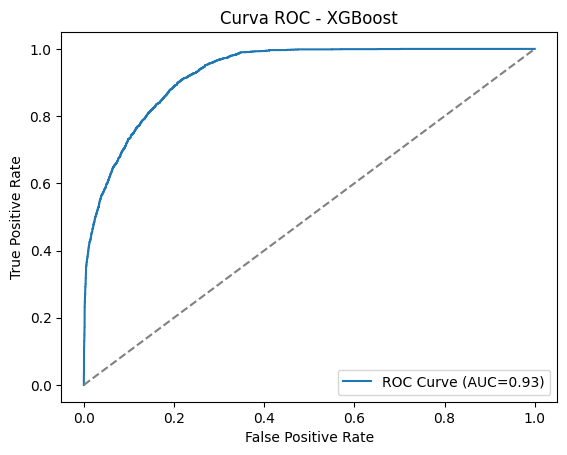

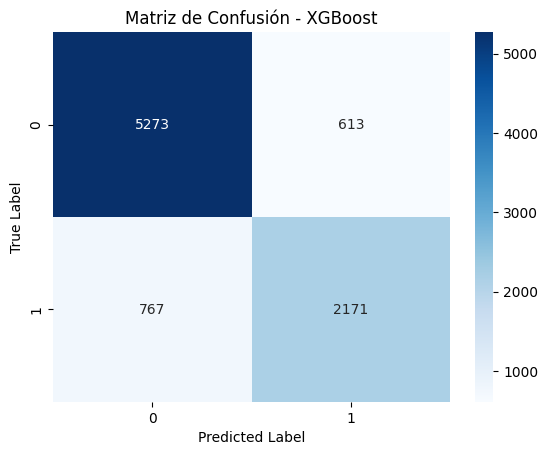


--------------------------------------------------
Modelo Optimizado 38
--------------------------------------------------
n_estimators: 200, Learning Rate: 0.1, Max Depth: 8, Min Child Weight: 1

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      5886
           1       0.78      0.74      0.76      2938

    accuracy                           0.84      8824
   macro avg       0.83      0.82      0.82      8824
weighted avg       0.84      0.84      0.84      8824


ROC-AUC Score: 0.9296899196834246



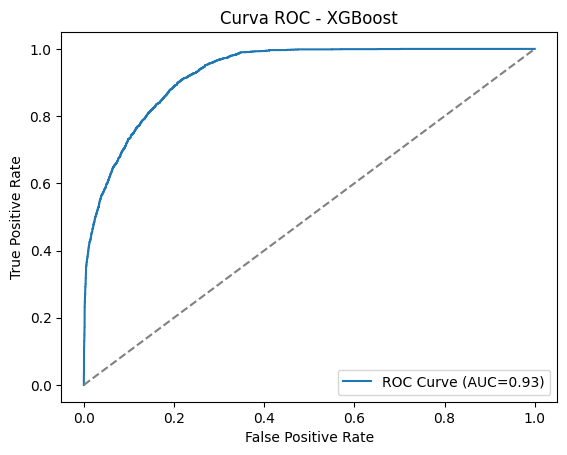

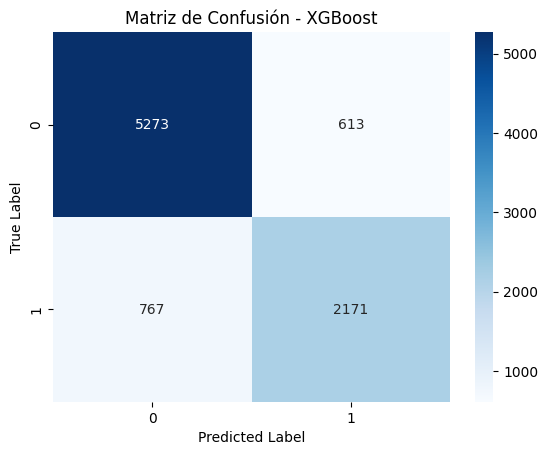


--------------------------------------------------
Modelo Optimizado 43
--------------------------------------------------
n_estimators: 200, Learning Rate: 0.1, Max Depth: 8, Min Child Weight: 3

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      5886
           1       0.78      0.74      0.76      2938

    accuracy                           0.84      8824
   macro avg       0.83      0.82      0.82      8824
weighted avg       0.84      0.84      0.84      8824


ROC-AUC Score: 0.9296899196834246



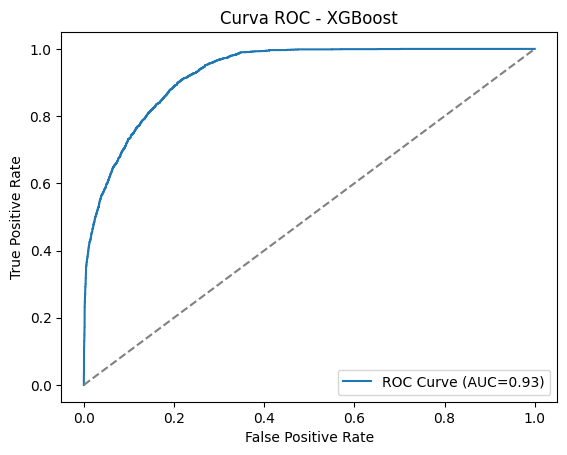

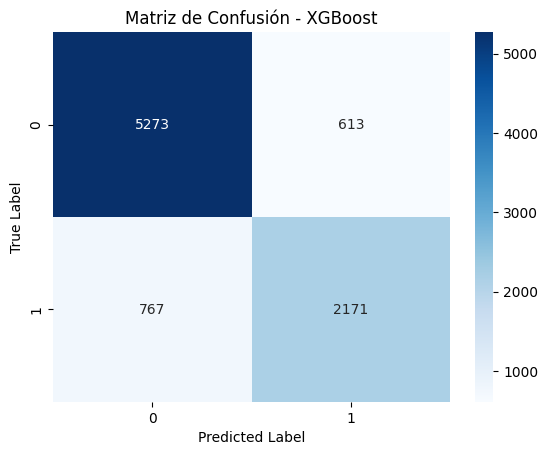

,n_estimators,learning_rate,max_depth,min_child_weight,gamma,subsample,colsample_bytree,accuracy,precision,f1_score,recall,roc_auc,cv_score,train_score,overfitting
34,200,0.1,8,1,0.2,0.9,0.7,0.845875,0.844100,0.844600,0.845875,0.930964,0.929635,0.942371,OK
37,200,0.1,8,1,0.3,0.8,0.9,0.844855,0.843608,0.844086,0.844855,0.929667,0.928614,0.951863,OK
42,200,0.1,8,3,0.2,0.9,0.7,0.844968,0.843260,0.843777,0.844968,0.929938,0.929094,0.931237,OK


In [8]:
# 1️⃣ Cargar y preparar datos
df = df.drop(columns=["Tiempo"], errors="ignore")  # Eliminar columna irrelevante
y = df["Mas_1_coche"]
X = df.drop(columns=["Mas_1_coche"])

# 2️⃣ Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 3️⃣ Definir los parámetros a iterar
param_grid = {
    'n_estimators': [200, 250],  
    'learning_rate': [0.1],  
    'max_depth': [4, 6, 8],  
    'min_child_weight': [1, 3],  
    'gamma': [0.2, 0.3],  
    'subsample': [0.8, 0.9],  
    'colsample_bytree': [0.7, 0.9]  
}

# 4️⃣ Almacenar resultados
results = []

# 5️⃣ Iterar sobre combinaciones de hiperparámetros
for params in product(*param_grid.values()):
    (n_estimators, learning_rate, max_depth, min_child_weight, gamma, subsample, colsample_bytree) = params

    print(f"Probando: n_estimators={n_estimators}, learning_rate={learning_rate}, max_depth={max_depth}, min_child_weight={min_child_weight}, gamma={gamma}, subsample={subsample}, colsample_bytree={colsample_bytree}")

    #  6️⃣ Entrenar modelo XGBoost con la configuración actual
    model = XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=1.0, 
        reg_alpha=0.0,  
        random_state=42,
        n_jobs=-1  
    )

    model.fit(X_train, y_train)

    # 7️⃣ Predicción y evaluación
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # 8️⃣ Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # 9️⃣ Validación cruzada (cv=5 para mejor estabilidad)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1)  
    mean_cv_score = np.mean(cv_scores)

    # 🔟 Calcular Train Score
    train_score = model.score(X_train, y_train)

    # 📌 🚨 Determinar si hay sobreajuste
    if train_score > 1.5 * mean_cv_score:
        overfitting_warning = "SEVERE OVERFITTING"
    elif train_score > 1.2 * mean_cv_score:
        overfitting_warning = "DANGER"
    elif train_score > 1.1 * mean_cv_score:
        overfitting_warning = "MILD OVERFITTING"
    else:
        overfitting_warning = "OK"

    #  Guardar los resultados
    results.append({
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'accuracy': accuracy,
        'precision': precision,
        'f1_score': f1,
        'recall': recall,
        'roc_auc': roc_auc,
        'cv_score': mean_cv_score,
        'train_score': train_score,
        'overfitting': overfitting_warning
    })

    # Mostrar resultados parciales
    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, ROC-AUC: {roc_auc:.4f}")
    print(f"CV Score: {mean_cv_score:.4f}, Train Score: {train_score:.4f}, Overfitting: {overfitting_warning}\n")

# 1️⃣1️⃣ Convertir resultados a DataFrame y seleccionar los mejores modelos
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['f1_score', 'accuracy'], ascending=False)

# 1️⃣2️⃣ Seleccionar los mejores 3 modelos sin sobreajuste
best_models = results_df[results_df['overfitting'] == 'OK'].head(3)

#  1️⃣3️⃣ Mostrar los mejores modelos con detalles
for index, row in best_models.iterrows():
    print('\n' + '-' * 50)
    print(f'Modelo Optimizado {index + 1}')
    print('-' * 50)
    print(f'n_estimators: {row["n_estimators"]}, Learning Rate: {row["learning_rate"]}, Max Depth: {row["max_depth"]}, Min Child Weight: {row["min_child_weight"]}')
    print(f'\nClassification Report:')
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    if len(np.unique(y_test)) > 1:
        y_pred_proba = model.predict_proba(X_test)[:, 1] 
        print(f'\nROC-AUC Score: {roc_auc}\n')

        # 📌 Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Curva ROC - XGBoost')
        plt.legend()
        plt.show()

        # 📌 Matriz de confusión
        plt.figure()
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusión - XGBoost')
        plt.show()

# 📌 Mostrar los mejores modelos
from IPython.display import display
display(best_models)



Modelo 38 entrenado con:
{'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.3, 'subsample': 0.8, 'colsample_bytree': 0.9, 'accuracy': 0.8411151405258386, 'precision': 0.8395841875342821, 'f1_score': 0.8401250264903918, 'recall': 0.8411151405258386, 'roc_auc': 0.9289744595927109, 'cv_score': 0.9280809115024109, 'train_score': 0.9369032440855646, 'overfitting': 'OK'}

Accuracy: 0.8411
F1 Score: 0.8401
ROC-AUC Score: 0.9290


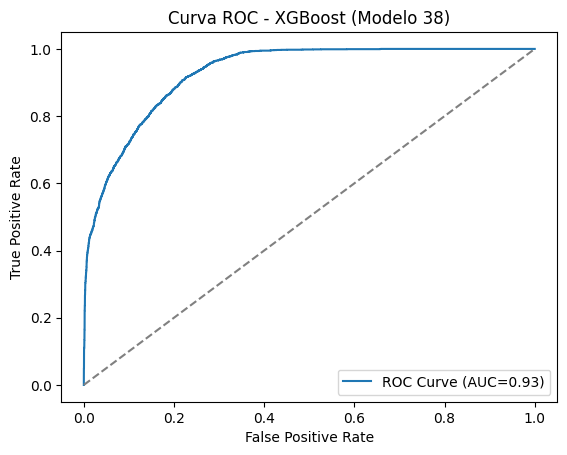

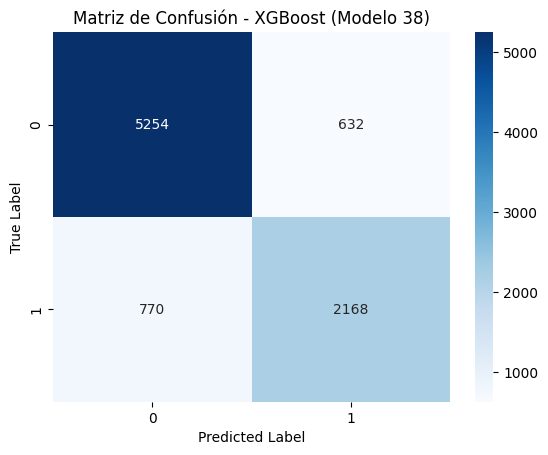

In [9]:
import joblib

# Obtener los parámetros del Modelo 38
best_params = results_df.iloc[37] 

# Entrenar el modelo con la mejor configuración
best_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=int(best_params["n_estimators"]),
    learning_rate=best_params["learning_rate"],
    max_depth=int(best_params["max_depth"]),
    min_child_weight=int(best_params["min_child_weight"]),
    gamma=best_params["gamma"],
    subsample=best_params["subsample"],
    colsample_bytree=best_params["colsample_bytree"],
    reg_lambda=1.0,
    reg_alpha=0.0,
    random_state=42,
    n_jobs=-1
)

best_model.fit(X_train, y_train)


joblib.dump(best_model, "mejor_modelo_xgb.pkl")

#Cargar el modelo a un arhivo para pdoer entrenarlo siempre
best_model = joblib.load("mejor_modelo_xgb.pkl")

#Hacer predicciones
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

#Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_proba)

#Mostrar métricas finales
print(f"Modelo 38 entrenado con:")
print(best_params.to_dict())
print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

#Mostrar la Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Curva ROC - XGBoost (Modelo 38)')
plt.legend()
plt.show()

#Matriz de confusión
plt.figure()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Matriz de Confusión - XGBoost (Modelo 38)')
plt.show()



🚀 Probando con Propensity_clean_v1.csv ...

--------------------------------------------------
Modelo aplicado a Propensity_clean_v1.csv
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5886
           1       0.77      0.74      0.76      2938

    accuracy                           0.84      8824
   macro avg       0.82      0.82      0.82      8824
weighted avg       0.84      0.84      0.84      8824


ROC-AUC Score: 0.9290



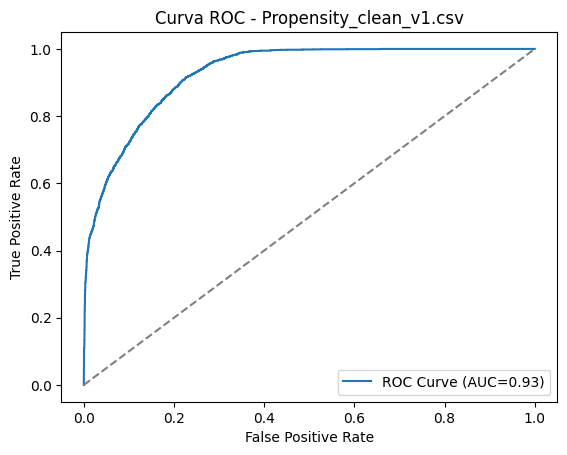

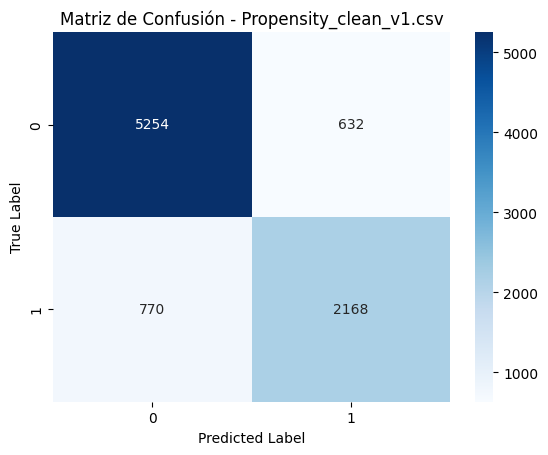


🚀 Probando con Propensity_clean_v2.csv ...

--------------------------------------------------
Modelo aplicado a Propensity_clean_v2.csv
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      8222
           1       0.63      0.82      0.71      3388

    accuracy                           0.81     11610
   macro avg       0.77      0.81      0.78     11610
weighted avg       0.83      0.81      0.81     11610


ROC-AUC Score: 0.8865



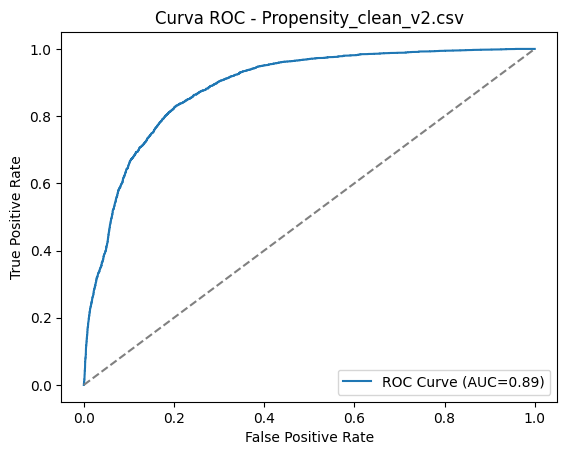

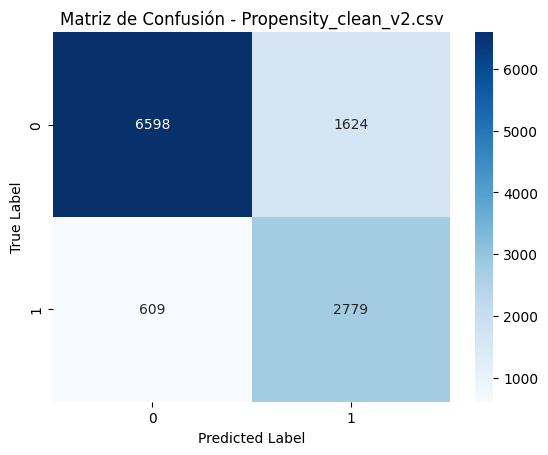


🚀 Probando con Propensity_clean_v3.csv ...

--------------------------------------------------
Modelo aplicado a Propensity_clean_v3.csv
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.79      0.85      8222
           1       0.63      0.84      0.72      3388

    accuracy                           0.81     11610
   macro avg       0.78      0.82      0.79     11610
weighted avg       0.84      0.81      0.81     11610


ROC-AUC Score: 0.8852



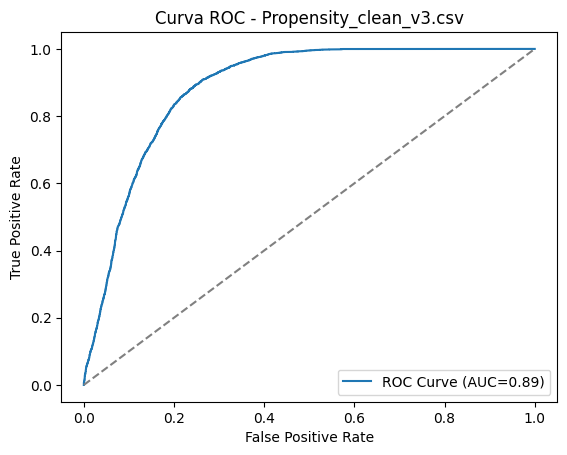

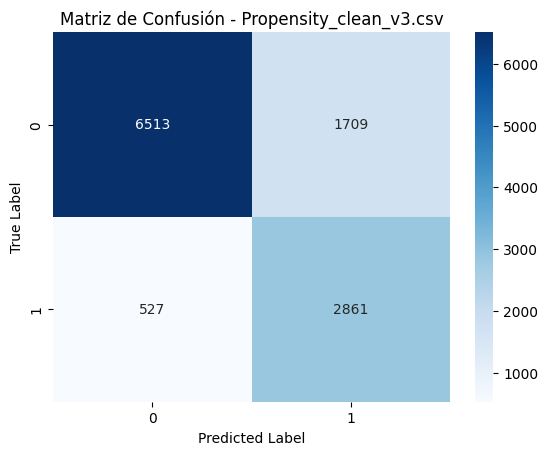


🚀 Probando con Propensity_clean_v4.csv ...

--------------------------------------------------
Modelo aplicado a Propensity_clean_v4.csv
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.79      0.85      8222
           1       0.63      0.84      0.72      3388

    accuracy                           0.81     11610
   macro avg       0.78      0.82      0.79     11610
weighted avg       0.84      0.81      0.81     11610


ROC-AUC Score: 0.8852



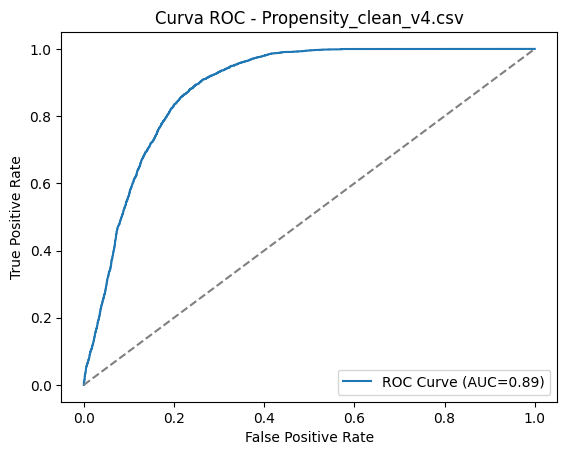

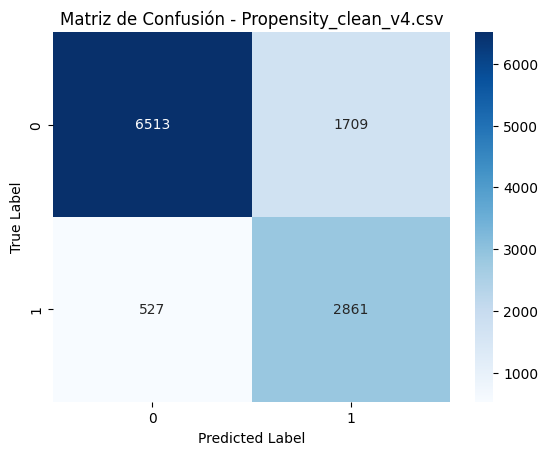

In [10]:
import os
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve

# 📌 Definir rutas
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data", "processed")

# 📌 Lista de versiones a probar
versions = ["v1", "v2", "v3", "v4"]

# 📌 Cargar el mejor modelo entrenado previamente
best_model = joblib.load("mejor_modelo_xgb.pkl")

# 📌 Iterar sobre cada versión del dataset
for version in versions:
    file_name = f"Propensity_clean_{version}.csv"
    file_path = os.path.join(DATA_DIR, file_name)

    print(f"\n🚀 Probando con {file_name} ...")

    # 📌 Cargar datos
    df = pd.read_csv(file_path)

    # 📌 Preparar datos
    df = df.drop(columns=["Tiempo"], errors="ignore")  # Eliminar columna irrelevante
    y = df["Mas_1_coche"]
    X = df.drop(columns=["Mas_1_coche"])

    # 📌 Dividir en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # 📌 Hacer predicciones
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # 📌 Evaluar el modelo
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # 📌 Mostrar métricas detalladas
    print('\n' + '-' * 50)
    print(f'Modelo aplicado a {file_name}')
    print('-' * 50)
    print(f'\nClassification Report:')
    print(classification_report(y_test, y_pred))

    print(f'\nROC-AUC Score: {roc_auc:.4f}\n')

    # 📌 Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {file_name}')
    plt.legend()
    plt.show()

    # 📌 Matriz de confusión
    plt.figure()
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Matriz de Confusión - {file_name}')
    plt.show()



🚀 Entrenando manualmente con Propensity_clean_v1.csv ...

--------------------------------------------------
Modelo entrenado manualmente con Propensity_clean_v1.csv
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5886
           1       0.77      0.74      0.76      2938

    accuracy                           0.84      8824
   macro avg       0.82      0.82      0.82      8824
weighted avg       0.84      0.84      0.84      8824


ROC-AUC Score: 0.9290



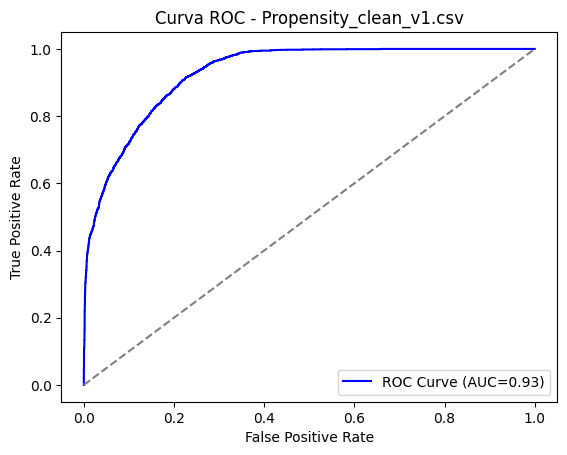

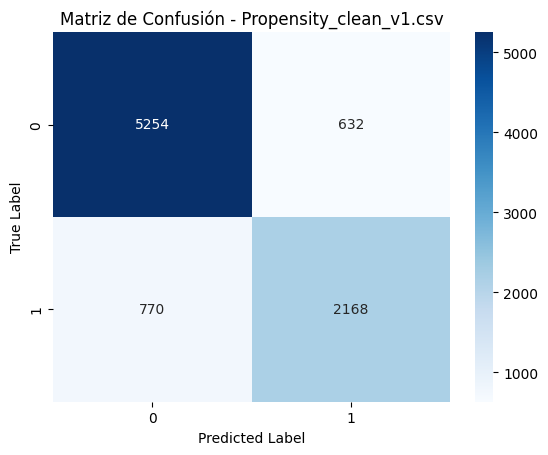


🚀 Entrenando manualmente con Propensity_clean_v2.csv ...

--------------------------------------------------
Modelo entrenado manualmente con Propensity_clean_v2.csv
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      8222
           1       0.80      0.76      0.78      3388

    accuracy                           0.87     11610
   macro avg       0.85      0.84      0.84     11610
weighted avg       0.87      0.87      0.87     11610


ROC-AUC Score: 0.9485



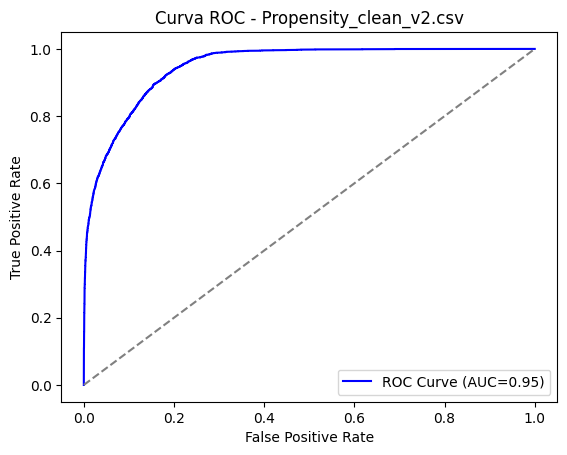

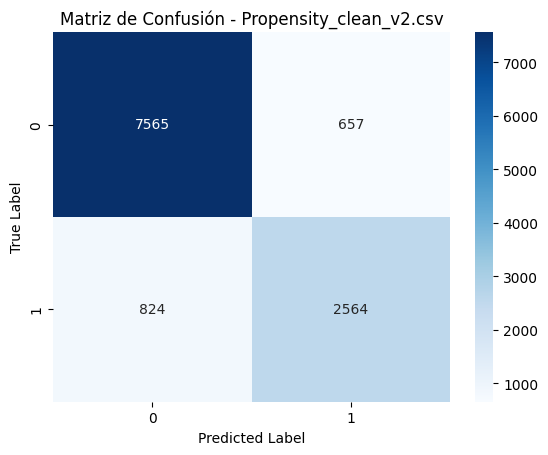


🚀 Entrenando manualmente con Propensity_clean_v3.csv ...

--------------------------------------------------
Modelo entrenado manualmente con Propensity_clean_v3.csv
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      8222
           1       0.76      0.66      0.71      3388

    accuracy                           0.84     11610
   macro avg       0.81      0.79      0.80     11610
weighted avg       0.84      0.84      0.84     11610


ROC-AUC Score: 0.9114



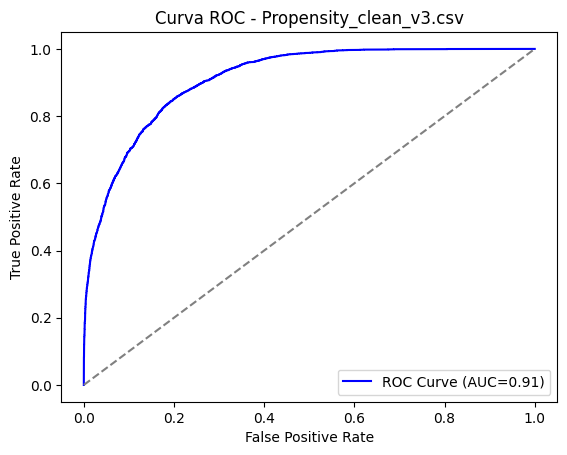

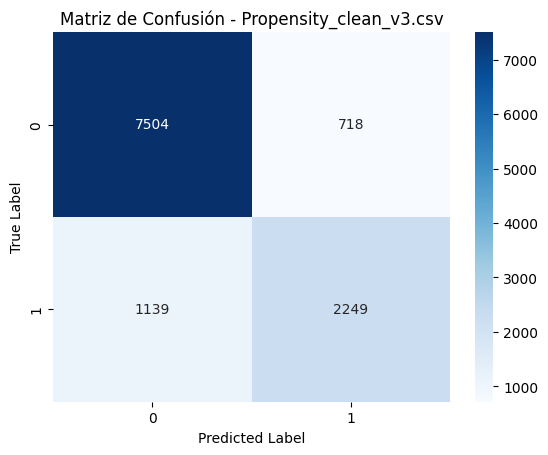


🚀 Entrenando manualmente con Propensity_clean_v4.csv ...

--------------------------------------------------
Modelo entrenado manualmente con Propensity_clean_v4.csv
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      8222
           1       0.76      0.67      0.72      3388

    accuracy                           0.84     11610
   macro avg       0.82      0.79      0.80     11610
weighted avg       0.84      0.84      0.84     11610


ROC-AUC Score: 0.9120



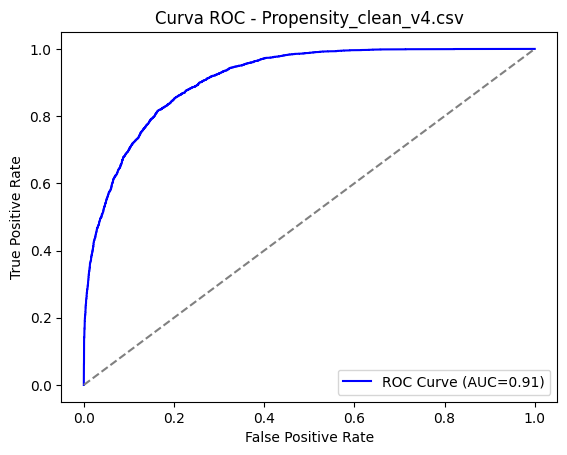

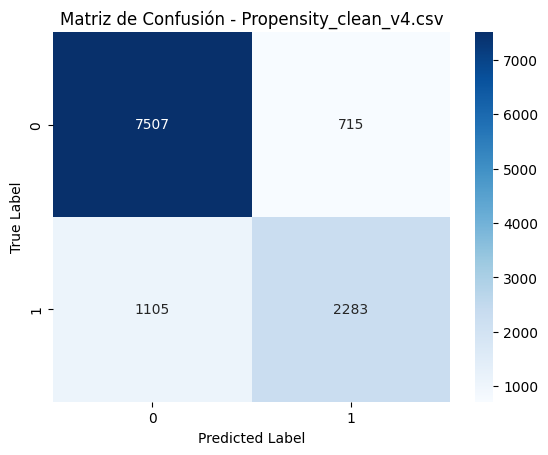

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve

# 📌 Definir rutas
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data", "processed")

# 📌 Lista de versiones de datasets a probar
versions = ["v1", "v2", "v3", "v4"]

# 📌 Definir los hiperparámetros del Modelo 38
modelo_38_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "n_estimators": 200,
    "learning_rate": 0.1,
    "max_depth": 8,
    "min_child_weight": 3,
    "gamma": 0.3,
    "subsample": 0.8,
    "colsample_bytree": 0.9,
    "reg_lambda": 1.0,
    "reg_alpha": 0.0,
    "random_state": 42,
    "n_jobs": -1
}

# 📌 Iterar sobre cada versión del dataset y entrenar manualmente
for version in versions:
    file_name = f"Propensity_clean_{version}.csv"
    file_path = os.path.join(DATA_DIR, file_name)

    print(f"\n🚀 Entrenando manualmente con {file_name} ...")

    # 📌 Cargar datos
    df = pd.read_csv(file_path)

    # 📌 Preparar datos
    df = df.drop(columns=["Tiempo"], errors="ignore")  # Eliminar columna irrelevante
    y = df["Mas_1_coche"]
    X = df.drop(columns=["Mas_1_coche"])

    # 📌 Dividir en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # 📌 Crear el modelo con los hiperparámetros del Modelo 38
    model = XGBClassifier(**modelo_38_params)

    # 📌 Entrenar modelo
    model.fit(X_train, y_train)

    # 📌 Hacer predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # 📌 Evaluar el modelo
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # 📌 Mostrar métricas detalladas
    print('\n' + '-' * 50)
    print(f'Modelo entrenado manualmente con {file_name}')
    print('-' * 50)
    print(f'\nClassification Report:')
    print(classification_report(y_test, y_pred))

    print(f'\nROC-AUC Score: {roc_auc:.4f}\n')

    # 📌 Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.2f})", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {file_name}')
    plt.legend()
    plt.show()

    # 📌 Matriz de confusión
    plt.figure()
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Matriz de Confusión - {file_name}')
    plt.show()



🚀 Entrenando manualmente con Propensity_clean_v1.csv ...
Dataset v1 tiene forma: (44119, 23)

--------------------------------------------------
Modelo entrenado manualmente con Propensity_clean_v1.csv
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5886
           1       0.77      0.74      0.76      2938

    accuracy                           0.84      8824
   macro avg       0.82      0.82      0.82      8824
weighted avg       0.84      0.84      0.84      8824


ROC-AUC Score: 0.9290



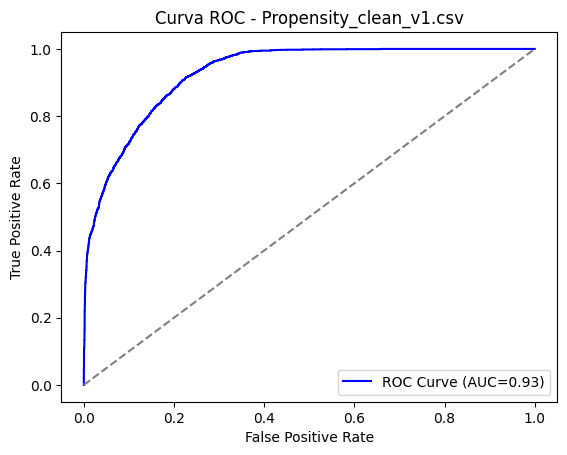

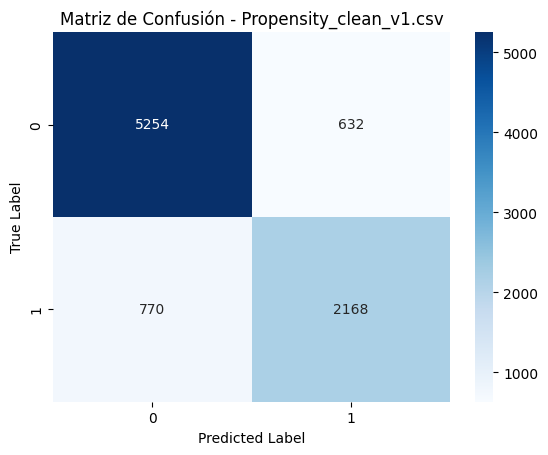


🚀 Entrenando manualmente con Propensity_clean_v2.csv ...
Dataset v2 tiene forma: (58048, 23)

--------------------------------------------------
Modelo entrenado manualmente con Propensity_clean_v2.csv
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      8222
           1       0.80      0.76      0.78      3388

    accuracy                           0.87     11610
   macro avg       0.85      0.84      0.84     11610
weighted avg       0.87      0.87      0.87     11610


ROC-AUC Score: 0.9485



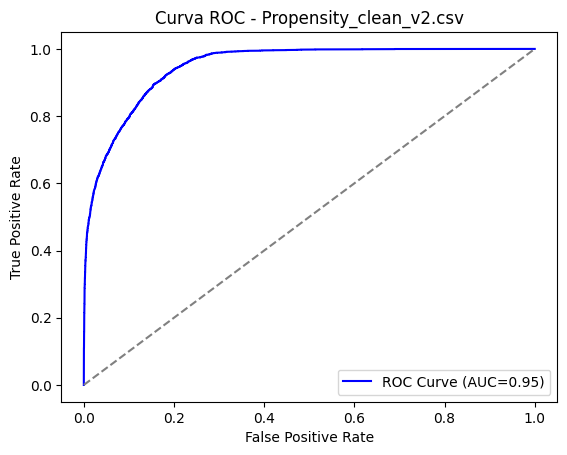

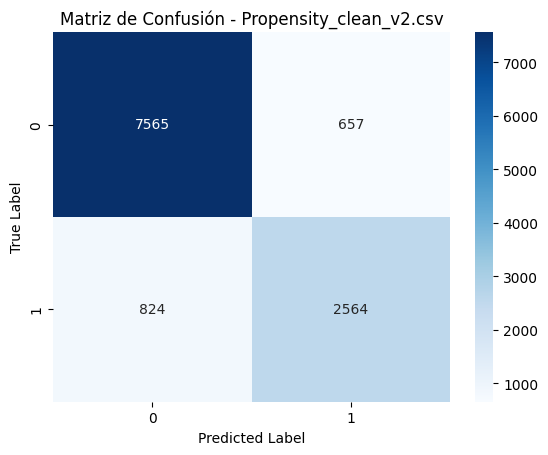


🚀 Entrenando manualmente con Propensity_clean_v3.csv ...
Dataset v3 tiene forma: (58048, 23)

--------------------------------------------------
Modelo entrenado manualmente con Propensity_clean_v3.csv
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      8222
           1       0.76      0.66      0.71      3388

    accuracy                           0.84     11610
   macro avg       0.81      0.79      0.80     11610
weighted avg       0.84      0.84      0.84     11610


ROC-AUC Score: 0.9114



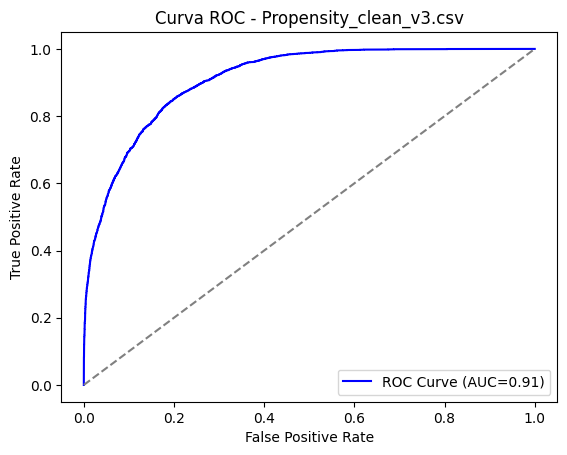

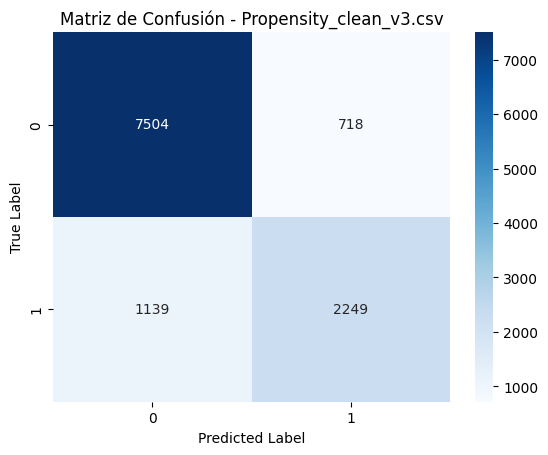


🚀 Entrenando manualmente con Propensity_clean_v4.csv ...
Dataset v4 tiene forma: (58048, 23)

--------------------------------------------------
Modelo entrenado manualmente con Propensity_clean_v4.csv
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      8222
           1       0.76      0.67      0.72      3388

    accuracy                           0.84     11610
   macro avg       0.82      0.79      0.80     11610
weighted avg       0.84      0.84      0.84     11610


ROC-AUC Score: 0.9120



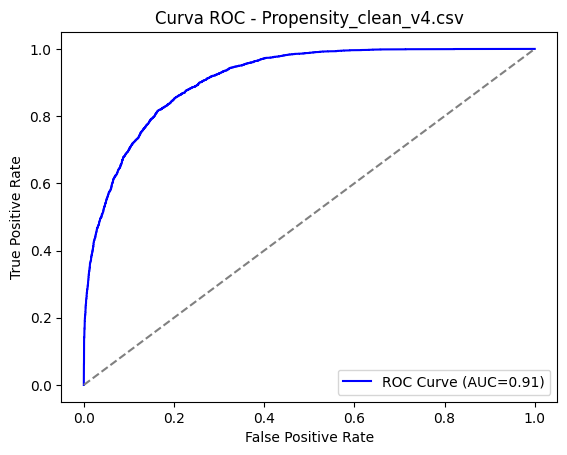

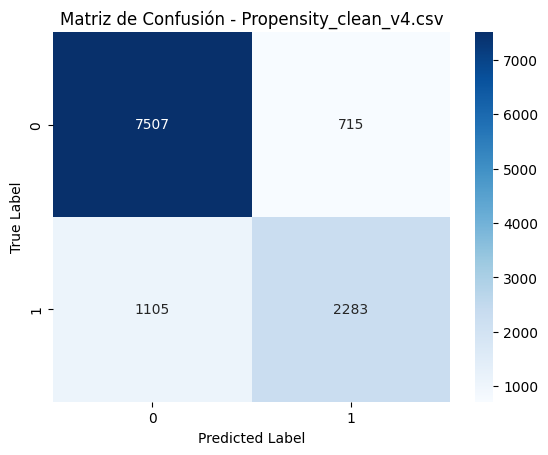

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve

# 📌 Definir rutas
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data", "processed")

# 📌 Lista de versiones de datasets a probar
versions = ["v1", "v2", "v3", "v4"]

# 📌 Definir los hiperparámetros del Modelo 38
modelo_38_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "n_estimators": 200,
    "learning_rate": 0.1,
    "max_depth": 8,
    "min_child_weight": 3,
    "gamma": 0.3,
    "subsample": 0.8,
    "colsample_bytree": 0.9,
    "reg_lambda": 1.0,
    "reg_alpha": 0.0,
    "random_state": 42,
    "n_jobs": -1
}

# 📌 Iterar sobre cada versión del dataset y entrenar manualmente
for version in versions:
    file_name = f"Propensity_clean_{version}.csv"
    file_path = os.path.join(DATA_DIR, file_name)

    print(f"\n🚀 Entrenando manualmente con {file_name} ...")

    # 📌 Cargar datos
    df = pd.read_csv(file_path)
    print(f"Dataset {version} tiene forma: {df.shape}")  # Para verificar diferencias

    # 📌 Preparar datos
    df = df.drop(columns=["Tiempo"], errors="ignore")  # Eliminar columna irrelevante
    y = df["Mas_1_coche"]
    X = df.drop(columns=["Mas_1_coche"])

    # 📌 Dividir en conjunto de entrenamiento y prueba (misma semilla random)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # 📌 Crear el modelo con los hiperparámetros del Modelo 38
    model = XGBClassifier(**modelo_38_params)

    # 📌 Entrenar modelo
    model.fit(X_train, y_train)

    # 📌 Hacer predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # 📌 Evaluar el modelo
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # 📌 Mostrar métricas detalladas
    print('\n' + '-' * 50)
    print(f'Modelo entrenado manualmente con {file_name}')
    print('-' * 50)
    print(f'\nClassification Report:')
    print(classification_report(y_test, y_pred))

    print(f'\nROC-AUC Score: {roc_auc:.4f}\n')

    # 📌 Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.2f})", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {file_name}')
    plt.legend()
    plt.show()

    # 📌 Matriz de confusión
    plt.figure()
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Matriz de Confusión - {file_name}')
    plt.show()
